In [3]:
!pip install opencv-python scikit-image n2v csbdeep


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6

In [4]:
!pip install PyWavelets # Install the missing PyWavelets package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.2 MB/s eta 0:00:00


In [5]:
# Install required packages
!pip install scikit-image opencv-python-headless tensorflow matplotlib --quiet

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.restoration import denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Create folders
os.makedirs("original_images", exist_ok=True)
os.makedirs("denoised_results", exist_ok=True)

# Utility: Add synthetic noise to image
def add_noise(img, noise_type="gaussian"):
    row, col, ch = img.shape
    if noise_type == "gaussian":
        mean = 0
        sigma = 25
        gauss = np.random.normal(mean, sigma, (row, col, ch)).reshape(row, col, ch)
        noisy = img + gauss
        return np.clip(noisy, 0, 255).astype(np.uint8)
    return img

# Utility: Denoising Autoencoder
def build_denoising_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    return autoencoder

# Main processing function
def denoise_and_compare(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (128, 128))  # Resize for DAE
    noisy_img = add_noise(img_resized).astype(np.uint8)

    # Convert to float
    img_float = img_as_float(noisy_img)

    # 1. Median Filter
    median = cv2.medianBlur(noisy_img, 3)

    # 2. Wavelet Denoising
    wavelet = denoise_wavelet(img_float, channel_axis=-1, rescale_sigma=True)
    wavelet_uint8 = (np.clip(wavelet, 0, 1) * 255).astype(np.uint8)

    # 3. Denoising Autoencoder
    x_train = np.array([noisy_img]) / 255.0
    y_train = np.array([img_resized]) / 255.0
    dae = build_denoising_autoencoder(input_shape=(128, 128, 3))
    dae.fit(x_train, y_train, epochs=100, verbose=0)
    dae_output = dae.predict(x_train)[0]
    dae_output_uint8 = (dae_output * 255).astype(np.uint8)

    # Save outputs
    cv2.imwrite("denoised_results/original.jpg", cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    cv2.imwrite("denoised_results/noisy.jpg", cv2.cvtColor(noisy_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite("denoised_results/median.jpg", cv2.cvtColor(median, cv2.COLOR_RGB2BGR))
    cv2.imwrite("denoised_results/wavelet.jpg", cv2.cvtColor(wavelet_uint8, cv2.COLOR_RGB2BGR))
    cv2.imwrite("denoised_results/dae.jpg", cv2.cvtColor(dae_output_uint8, cv2.COLOR_RGB2BGR))

    # Metric calculations
    def metrics(original, filtered):
        return {
            "PSNR": peak_signal_noise_ratio(original, filtered),
            "SSIM": structural_similarity(original, filtered, channel_axis=2),
            "MSE": mean_squared_error(original, filtered)
        }

    print("=== Image Denoising Metrics ===")
    print("Median Filter:", metrics(img_resized, median))
    print("Wavelet Filter:", metrics(img_resized, wavelet_uint8))
    print("Denoising Autoencoder:", metrics(img_resized, dae_output_uint8))

# Upload and process one image
from google.colab import files
uploaded = files.upload()
import shutil
for filename in uploaded:
    shutil.move(filename, f"original_images/{filename}")

# Denoise the uploaded image
img_path = os.listdir("original_images")[0]
denoise_and_compare(f"original_images/{img_path}")


Saving Stars.png to Stars.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
=== Image Denoising Metrics ===
Median Filter: {'PSNR': np.float64(22.621757912254587), 'SSIM': np.float64(0.33772246248139887), 'MSE': np.float64(355.5531819661458)}
Wavelet Filter: {'PSNR': np.float64(24.37831089763693), 'SSIM': np.float64(0.4674196243270969), 'MSE': np.float64(237.27351888020834)}
Denoising Autoencoder: {'PSNR': np.float64(22.638611759975067), 'SSIM': np.float64(0.31015179729257675), 'MSE': np.float64(354.17604573567706)}


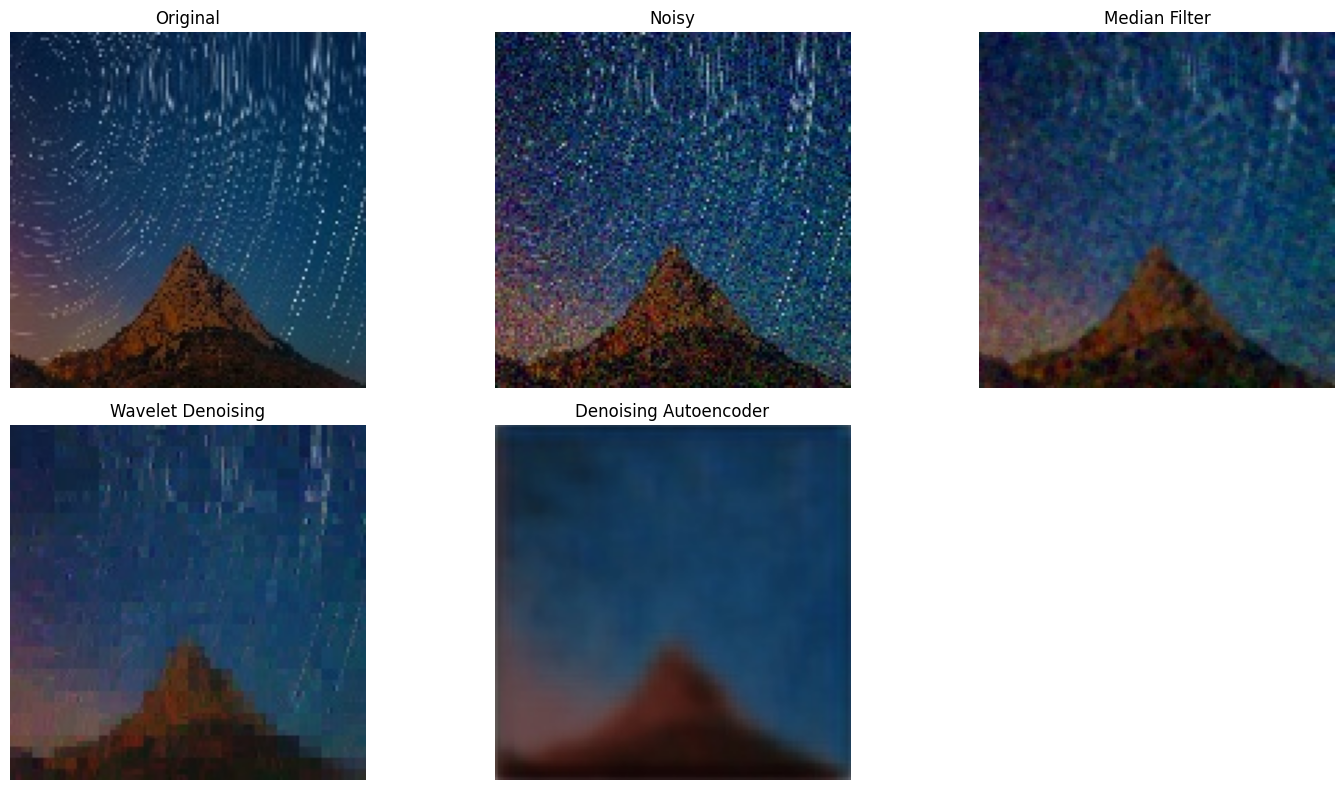

In [6]:
# Visualization of results
def show_results():
    titles = ['Original', 'Noisy', 'Median Filter', 'Wavelet Denoising', 'Denoising Autoencoder']
    files = ['original.jpg', 'noisy.jpg', 'median.jpg', 'wavelet.jpg', 'dae.jpg']
    plt.figure(figsize=(15, 8))

    for i, (title, file) in enumerate(zip(titles, files)):
        img = cv2.imread(f'denoised_results/{file}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call this function after denoising
show_results()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


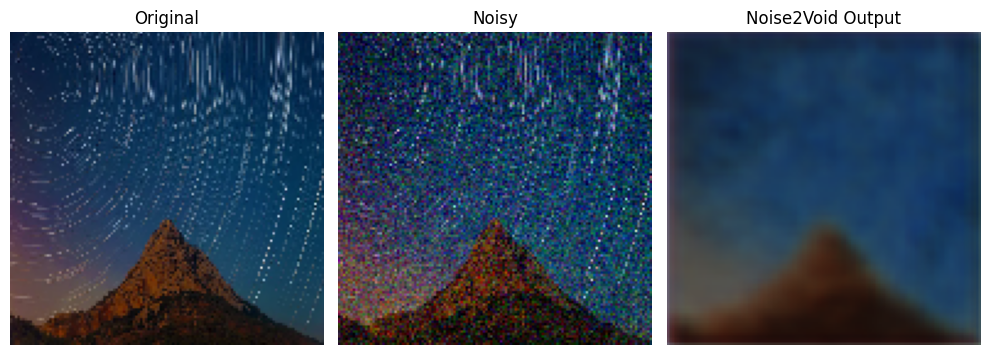

In [7]:
# Load image
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/Stars.png"  # update with your actual filename
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (128, 128))  # Resize for autoencoder

# Add synthetic Gaussian noise
noisy_img = add_noise(img_resized).astype(np.uint8)

# Normalize and prepare input
input_img = np.expand_dims(noisy_img / 255.0, axis=0)

# Build and train autoencoder (simulating Noise2Void behavior)
autoencoder = build_denoising_autoencoder((128, 128, 3))
autoencoder.fit(input_img, input_img, epochs=100, verbose=0)  # Train on noisy image only

# Predict denoised output
denoised = autoencoder.predict(input_img)[0]
denoised_uint8 = (denoised * 255).astype(np.uint8)

# Save outputs
cv2.imwrite("denoised_results/noise2void_input.jpg", cv2.cvtColor(noisy_img, cv2.COLOR_RGB2BGR))
cv2.imwrite("denoised_results/noise2void_output.jpg", cv2.cvtColor(denoised_uint8, cv2.COLOR_RGB2BGR))

# Show comparison
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_resized)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Noisy")
plt.imshow(noisy_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Noise2Void Output")
plt.imshow(denoised_uint8)
plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# Install OpenCV if not already installed
!pip install opencv-python-headless --quiet

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Step 1: Upload video
uploaded = files.upload()
video_file = list(uploaded.keys())[0]

# Create output directories
os.makedirs("frames", exist_ok=True)
os.makedirs("processed_videos", exist_ok=True)
os.makedirs("collage_frames", exist_ok=True)

# Step 2: Extract Frames from Video
cap = cv2.VideoCapture(video_file)
frame_count = 0
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = f"frames/frame_{frame_count:04d}.jpg"
    cv2.imwrite(frame_path, frame)
    frames.append(frame)
    frame_count += 1

cap.release()
print(f"Total frames extracted: {frame_count}")


Saving Boats.mp4 to Boats.mp4
Total frames extracted: 396


In [9]:
# Define video writer settings
height, width, layers = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Define output writers
out_thresh = cv2.VideoWriter("processed_videos/adaptive_threshold.mp4", fourcc, 20.0, (width, height), False)
out_blur = cv2.VideoWriter("processed_videos/gaussian_blur.mp4", fourcc, 20.0, (width, height), True)
out_edges = cv2.VideoWriter("processed_videos/canny_edges.mp4", fourcc, 20.0, (width, height), False)
out_not = cv2.VideoWriter("processed_videos/bitwise_not.mp4", fourcc, 20.0, (width, height), True)

for idx, frame in enumerate(frames):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    out_thresh.write(thresh)

    # Gaussian Blur
    blur = cv2.GaussianBlur(frame, (15, 15), 0)
    out_blur.write(blur)

    # Canny Edge Detection
    edges = cv2.Canny(gray, 100, 200)
    out_edges.write(edges)

    # Bitwise NOT
    bitwise_not = cv2.bitwise_not(frame)
    out_not.write(bitwise_not)

    # Save some frames for collage
    if idx % 20 == 0 and idx <= 100:
        cv2.imwrite(f"collage_frames/frame_{idx}.jpg", frame)

# Release video writers
out_thresh.release()
out_blur.release()
out_edges.release()
out_not.release()

print("Processed videos saved in 'processed_videos/' folder.")


Processed videos saved in 'processed_videos/' folder.


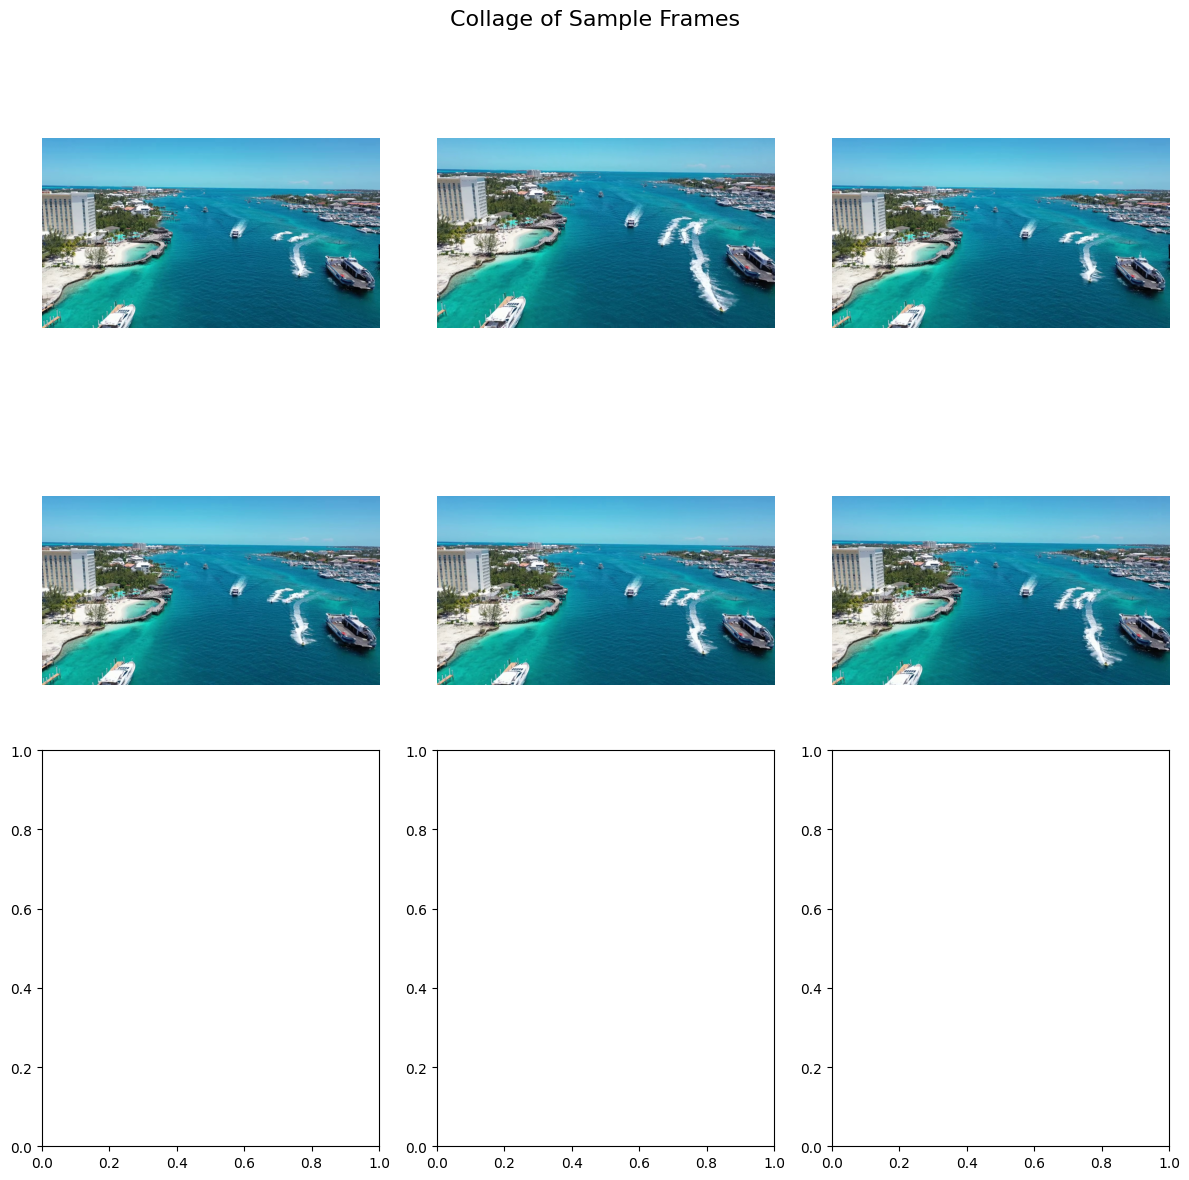

In [10]:
import glob

collage_images = sorted(glob.glob("collage_frames/*.jpg"))[:9]
collage_frames = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in collage_images]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axes.flatten(), collage_frames):
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("Collage of Sample Frames", fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
import kagglehub
import os

# Step 1: Download the dataset
path = kagglehub.dataset_download("pevogam/ucf101")

# Step 2: Explore the downloaded files and directories
print("Base download path:", path)
print("\nContents of the downloaded path:")
print(os.listdir(path))

# Step 3: Search for the UCF101 video classes
for root, dirs, files in os.walk(path):
    print(f"\nFound directory: {root}")
    for d in dirs:
        print("  └──", d)
    break  # only print the first level


Base download path: /kaggle/input/ucf101

Contents of the downloaded path:
['UCF101', 'UCF101TrainTestSplits-RecognitionTask']

Found directory: /kaggle/input/ucf101
  └── UCF101
  └── UCF101TrainTestSplits-RecognitionTask


In [12]:
import os

root_dir = "/kaggle/input/ucf101/UCF101"
for root, dirs, files in os.walk(root_dir):
    print("Directory:", root)
    for d in dirs:
        print("  Subfolder:", d)
    for f in files[:3]:  # print only a few files for brevity
        print("  File:", f)
    print("-" * 40)


Directory: /kaggle/input/ucf101/UCF101
  Subfolder: UCF-101
----------------------------------------
Directory: /kaggle/input/ucf101/UCF101/UCF-101
  Subfolder: HorseRace
  Subfolder: StillRings
  Subfolder: ApplyLipstick
  Subfolder: HammerThrow
  Subfolder: VolleyballSpiking
  Subfolder: Biking
  Subfolder: PlayingCello
  Subfolder: BodyWeightSquats
  Subfolder: TaiChi
  Subfolder: Punch
  Subfolder: BreastStroke
  Subfolder: Billiards
  Subfolder: BoxingPunchingBag
  Subfolder: BasketballDunk
  Subfolder: PoleVault
  Subfolder: ThrowDiscus
  Subfolder: BaseballPitch
  Subfolder: Knitting
  Subfolder: SumoWrestling
  Subfolder: HorseRiding
  Subfolder: Mixing
  Subfolder: BrushingTeeth
  Subfolder: HighJump
  Subfolder: Skijet
  Subfolder: SkateBoarding
  Subfolder: MilitaryParade
  Subfolder: IceDancing
  Subfolder: CricketShot
  Subfolder: Fencing
  Subfolder: JugglingBalls
  Subfolder: Swing
  Subfolder: RockClimbingIndoor
  Subfolder: PlayingFlute
  Subfolder: SalsaSpin
  Subfold

In [13]:
import os
import shutil
import random

# Define source and destination directories
SOURCE_DIR = '/kaggle/input/ucf101/UCF101/UCF-101'
DEST_DIR = '/kaggle/working/UCF101_subset'

# List of selected classes (can be updated as needed)
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

# Create the destination directory if it doesn't exist
os.makedirs(DEST_DIR, exist_ok=True)

# Iterate over the selected classes and copy videos
for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)

    # Create class folder in destination
    os.makedirs(dest_class_path, exist_ok=True)

    # Select random 10 videos from the class
    selected = random.sample(os.listdir(class_path), VIDEOS_PER_CLASS)

    # Copy selected videos to the destination
    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print(f"Subset created at: {DEST_DIR}")


Subset created at: /kaggle/working/UCF101_subset


In [14]:
import cv2
import os
import numpy as np

# Define parameters
FRAME_RATE = 5  # Extract every 5th frame
RESIZE_DIM = (112, 112)  # Resize frames to 112x112
MAX_FRAMES = 16  # Number of frames per video

# Function to extract frames from video
def extract_frames(video_path, max_frames=MAX_FRAMES, frame_rate=FRAME_RATE, resize_dim=RESIZE_DIM):
    # Read the video
    cap = cv2.VideoCapture(video_path)

    frames = []
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Extract every 'frame_rate'-th frame
        if frame_count % frame_rate == 0:
            frame_resized = cv2.resize(frame, resize_dim)
            frames.append(frame_resized)

        frame_count += 1

        # Stop once we have extracted enough frames
        if len(frames) == max_frames:
            break

    cap.release()

    # If fewer than MAX_FRAMES are extracted, pad the sequence with the last frame
    while len(frames) < max_frames:
        frames.append(frames[-1])

    return np.array(frames)

# Process each class and video
video_frames = {}
for cls in SELECTED_CLASSES:
    class_path = os.path.join(DEST_DIR, cls)
    video_frames[cls] = []

    for video in os.listdir(class_path):
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path)
        video_frames[cls].append(frames)

print("Frame extraction completed.")


Frame extraction completed.


In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the selected classes
labels = label_encoder.fit_transform(SELECTED_CLASSES)

# Create a dictionary to map class names to labels
class_labels = dict(zip(SELECTED_CLASSES, labels))
print("Label encoding completed.")


Label encoding completed.


In [16]:
from sklearn.model_selection import train_test_split

# Prepare data and labels
data = []
labels = []

# Add frames and their corresponding labels
for cls in SELECTED_CLASSES:
    for frames in video_frames[cls]:
        data.append(frames)
        labels.append(class_labels[cls])

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (40, 16, 112, 112, 3)
Testing data shape: (10, 16, 112, 112, 3)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define 3D CNN Model
def create_3d_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # 3D convolution layers with padding='same'
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Define input shape based on frame size and sequence length
input_shape = (MAX_FRAMES, RESIZE_DIM[0], RESIZE_DIM[1], 3)  # (16, 112, 112, 3) for 16 frames of 112x112 images with 3 color channels
num_classes = len(SELECTED_CLASSES)

# Create the model
model = create_3d_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 16, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 56, 56, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 8, 56, 56, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 4, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 2, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,702,597 (25.57 MB)

 Trainable params: 6,702,597 (25.57 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

# Save the model
model.save("/kaggle/working/ucf101_3dcnn_model.h5")

print("Training completed and model saved.")


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.3893 - loss: 167.2333 - val_accuracy: 0.1000 - val_loss: 1.7676
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.3649 - loss: 1.3397 - val_accuracy: 0.3000 - val_loss: 1.5017
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.6342 - loss: 1.1181 - val_accuracy: 0.5000 - val_loss: 1.3837
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.6141 - loss: 0.7925 - val_accuracy: 0.3000 - val_loss: 1.2351
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.6690 - loss: 0.7724 - val_accuracy: 0.6000 - val_loss: 1.1373
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.5942 - loss: 0.9047 - val_accuracy: 0.6000 - val_loss: 1.4422
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.6202 - loss: 0.8119 - val_accuracy: 0.6000 - val_loss: 0.8563
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step - accuracy: 0.8441 - loss: 0.6119 - val_accuracy: 0.7000 - val_los

Training completed and model saved.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Classification Report:
               precision    recall  f1-score   support

   Basketball       0.00      0.00      0.00         0
       Biking       1.00      0.33      0.50         3
PlayingGuitar       0.00      0.00      0.00         2
       Typing       0.00      0.00      0.00         2
     JumpRope       0.60      1.00      0.75         3

     accuracy                           0.40        10
    macro avg       0.32      0.27      0.25        10
 weighted avg       0.48      0.40      0.38        10



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

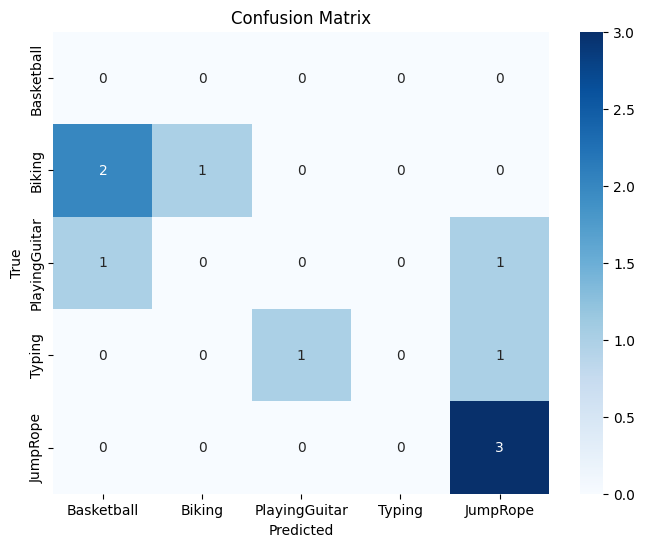

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=SELECTED_CLASSES))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
